Part of https://github.com/htdt/cartpole-solved

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
!pip install -q gym ipdb

In [0]:
from collections import deque
import gym, random, math, ipdb
from tqdm import trange
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

gym.logger.set_level(40)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
class DQN(nn.Module):
  input_dim = 4
  output_dim = 2
  hidden = 32
  quantile_dim = 8 # embedding dim

  def __init__(self):
    super(DQN, self).__init__()
    fc = lambda s_in, s_out: nn.Sequential(nn.Linear(s_in, s_out), nn.ReLU())
    self.features = fc(self.input_dim, self.hidden)
    self.quantile_fc = fc(self.quantile_dim, self.hidden)
    self.head_fc = fc(self.hidden, self.hidden)
    self.adv = nn.Linear(self.hidden, self.output_dim)
    self.val = nn.Linear(self.hidden, 1)

  def forward(self, x, num_quantiles):
    batch_size = x.shape[0]
    x = self.features(x) # batch x hidden
    x = x.repeat(num_quantiles, 1) # batch * num_quantiles x hidden
    qn, quantiles = self._get_quantile(batch_size * num_quantiles) # batch * num_quantiles x quantile_dim
    qn = self.quantile_fc(qn) # batch * num_quantiles x hidden
    x = x * qn
    x = self.head_fc(x)
    adv = self.adv(x)
    val = self.val(x)
    q = val + adv - adv.mean(1, keepdim=True)
    return q, quantiles

  def _get_quantile(self, size):
    quantiles = torch.empty(size, 1, dtype=torch.float32).uniform_()
    quantile_net = quantiles.repeat(1, self.quantile_dim)
    embedding_range = torch.arange(1, self.quantile_dim + 1, dtype=torch.float32).unsqueeze(0)
    return torch.cos(embedding_range * math.pi * quantile_net), quantiles


In [0]:
class Agent:
  output_dim = 2
  lr = 1e-3
  batch_size = 32
  gamma = 0.99

  kappa = 1  # Huber loss cutoff
  num_t = 8  # number of online quantile samples for loss estimation
  num_tp = 8 # number of target quantile samples for loss estimation
  num_q = 8  # number of quantile samples for computing Q-values

  def __init__(self):
    self.online_net = DQN()
    self.online_net.train()

    self.target_net = DQN()
    self.update_target_net()
    for param in self.target_net.parameters(): param.requires_grad = False

    self.optimiser = optim.Adam(self.online_net.parameters(), lr=self.lr)

  def act(self, state):
    state = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
      q, _ = self.online_net(state, self.num_q)
      return q.mean(0).argmax(0).item()

  def act_e_greedy(self, state, epsilon=0.01):
    if random.random() < epsilon:
      return random.randrange(self.output_dim)
    else:
      return self.act(state)

  def _target_quantile_values(self, reward, next_state, terminal):
    with torch.no_grad():
      reward = reward.repeat(self.num_tp)
      gamma_with_terminal = (self.gamma * (1 - terminal)).repeat(self.num_tp)

      # for action selection for the next states
      action_q, _ = self.online_net(next_state, self.num_q) # online_net to get action for next_state
      action_q = action_q.view(self.num_q, self.batch_size, self.output_dim).mean(0)
      actions = action_q.argmax(1) # batch_size
      actions = actions.repeat(self.num_tp)

      target_q, _ = self.target_net(next_state, self.num_tp) # target_net to get Q
      target_q = target_q[range(self.batch_size * self.num_tp), actions]

      return reward + gamma_with_terminal * target_q

  def _sample_batch(self, buffer):
    s, a, r, ns, t = zip(*random.sample(buffer, self.batch_size))
    f, l = torch.FloatTensor, torch.LongTensor
    return f(s), l(a), f(r), f(ns), f(t)
  
  def _huber_loss(self, bellman_errors):
    be_abs = bellman_errors.abs()
    huber_loss_1 = (be_abs <= self.kappa).float() * 0.5 * bellman_errors ** 2
    huber_loss_2 = (be_abs > self.kappa).float() * self.kappa * (be_abs - 0.5 * self.kappa)
    return huber_loss_1 + huber_loss_2
  
  def _same_shape(self, q_value, target_qv, quantiles): # batch x num_tp x num_t
    return q_value.view(self.num_t, self.batch_size).t().unsqueeze(1),\
      target_qv.view(self.num_tp, self.batch_size).t().unsqueeze(2),\
      quantiles.view(self.num_t, self.batch_size).t().unsqueeze(1).repeat(1, self.num_tp, 1)

  def train_iter(self, buffer):
    state, action, reward, next_state, terminal = self._sample_batch(buffer)
    
    q_values, quantiles = self.online_net(state, self.num_t)
    action = action.repeat(self.num_t)
    q_value = q_values[range(self.batch_size * self.num_t), action]

    target_qv = self._target_quantile_values(reward, next_state, terminal)

    q_value, target_qv, quantiles = self._same_shape(q_value, target_qv, quantiles)

    bellman_errors = target_qv - q_value
    huber_loss = self._huber_loss(bellman_errors)
    neg_errors = (bellman_errors.detach() < 0).float()
    quantile_huber_loss = (quantiles - neg_errors).abs() * huber_loss / self.kappa
    loss = quantile_huber_loss.sum(2).mean()

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    return loss.item()

  def update_target_net(self):
    self.target_net.load_state_dict(self.online_net.state_dict())

100%|██████████| 10000/10000 [01:37<00:00, 102.29it/s]


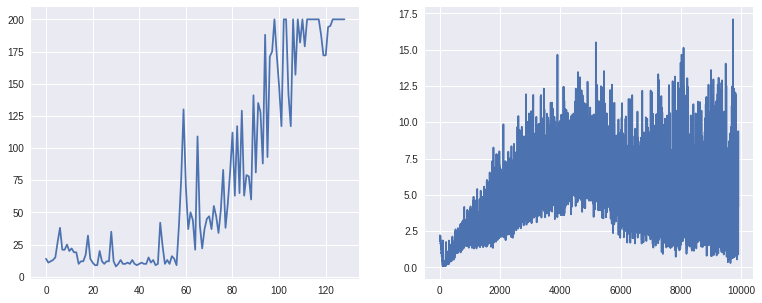

In [6]:
buffer = deque(maxlen=5000)
env = gym.make("CartPole-v0")
agent = Agent()

rewards, loss = [], []
episode_reward = 0
state = env.reset()

for i in trange(10000):
  eps = .01 + .99 * math.exp(-i / 500) # close to .01 at 3500
  action = agent.act_e_greedy(state, eps)
  next_state, reward, done, _ = env.step(action)
  buffer.append((state, action, reward, next_state, done))
  
  state = next_state
  episode_reward += reward
  
  if done:
    state = env.reset()
    rewards.append(episode_reward)
    episode_reward = 0
    
  if i > 100:
    loss.append(agent.train_iter(buffer))
   
  if i > 100 and i % 100 == 0:
    agent.update_target_net()

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(rewards)
plt.subplot(132)
plt.plot(loss)